## Import Required Libraries
We begin by importing all necessary Python libraries for:
- Data handling (`pandas`, `numpy`)
- Data visualization (`matplotlib`, `seaborn`)
- Preprocessing (`StandardScaler`, `OneHotEncoder`)
- Model building (`tensorflow.keras`)
- Evaluation (`confusion_matrix`, `accuracy_score`)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Input

## Load the Dataset
We load the provided `Churn_Modelling.csv` dataset into a DataFrame and examine its first few rows to understand its structure.

In [2]:
# Load dataset
df = pd.read_csv("Churn_Modelling.csv")
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Explore and Identify Significant Features (numeric-only)
The `Exited` column is our target variable (0 = stayed, 1 = left).
We restrict the correlation to numeric columns to avoid errors from string/categorical fields (e.g., `Surname`, `Geography`, `Gender`).
Then we also view the correlation of each numeric feature with the target `Exited`.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


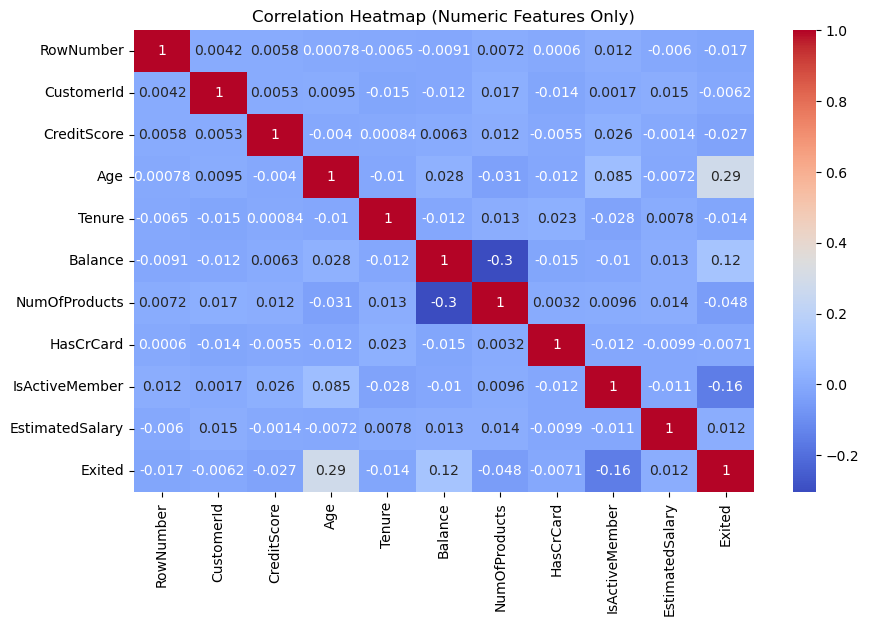

Correlation with Exited:
 Age                0.285323
IsActiveMember    -0.156128
Balance            0.118533
NumOfProducts     -0.047820
CreditScore       -0.027094
RowNumber         -0.016571
Tenure            -0.014001
EstimatedSalary    0.012097
HasCrCard         -0.007138
CustomerId        -0.006248
Name: Exited, dtype: float64


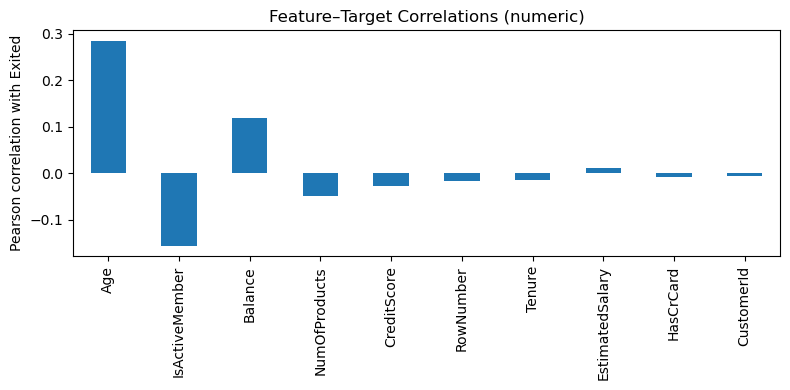

In [3]:
# Quick info
df.info()

# Select only numeric columns for correlation
num_df = df.select_dtypes(include=['number'])

# Heatmap of numeric correlations
plt.figure(figsize=(10,6))
corr_matrix = num_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap (Numeric Features Only)")
plt.show()

# Correlation of each numeric feature with target
target_corr = corr_matrix['Exited'].drop('Exited').sort_values(key=np.abs, ascending=False)
print("Correlation with Exited:\n", target_corr)

# Optional: bar plot of correlation with target
plt.figure(figsize=(8,4))
target_corr.plot(kind='bar')
plt.ylabel('Pearson correlation with Exited')
plt.title('Feature–Target Correlations (numeric)')
plt.tight_layout()
plt.show()

## Define Features (X) and Target (y)
We drop identifier-like columns (`RowNumber`, `CustomerId`, `Surname`) and keep `Exited` as the target.

In [4]:
# Features & target
X_raw = df.drop(columns=['RowNumber', 'CustomerId', 'Surname', 'Exited'])
y = df['Exited']

categorical_features = ['Geography', 'Gender']
numeric_features = [c for c in X_raw.columns if c not in categorical_features]
X_raw.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,France,Female,42,2,0.00,1,1,1,101348.88
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58
2,502,France,Female,42,8,159660.80,3,1,0,113931.57
3,699,France,Female,39,1,0.00,2,0,0,93826.63
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10


## Preprocess — One-Hot Encode categoricals & Scale numerics
We use a `ColumnTransformer` so:
- `Geography`, `Gender` → `OneHotEncoder(drop='first')` to avoid dummy trap
- numeric columns → `StandardScaler`

In [5]:
preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features),
        ('num', Pipeline([('scaler', StandardScaler())]), numeric_features)
    ],
    remainder='drop'
)

X = preprocess.fit_transform(X_raw)

# Keep feature names for later (e.g., mutual information listing)
ohe = preprocess.named_transformers_['cat']
cat_names = ohe.get_feature_names_out(categorical_features)
feature_names = list(cat_names) + numeric_features
len(feature_names), feature_names[:6]

(11,
 ['Geography_Germany',
  'Geography_Spain',
  'Gender_Male',
  'CreditScore',
  'Age',
  'Tenure'])

## Train-Test Split
We split the dataset into 80% training and 20% testing to evaluate the ANN’s performance on unseen data.

In [6]:
np.random.seed(42)
tf.random.set_seed(42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
y_train.value_counts(normalize=True), y_test.value_counts(normalize=True)

(Exited
 0    0.79625
 1    0.20375
 Name: proportion, dtype: float64,
 Exited
 0    0.7965
 1    0.2035
 Name: proportion, dtype: float64)

## Feature relevance via Mutual Information
Mutual information captures non-linear relationships and works with the one-hot encoded matrix.

In [7]:
from sklearn.feature_selection import mutual_info_classif
mi = mutual_info_classif(X_train, y_train, random_state=42)
mi_series = pd.Series(mi, index=feature_names).sort_values(ascending=False)
mi_series.head(10)

Age                  0.072579
NumOfProducts        0.069746
Geography_Germany    0.016638
IsActiveMember       0.012721
Balance              0.007483
Tenure               0.005245
EstimatedSalary      0.002665
CreditScore          0.002052
Gender_Male          0.001120
HasCrCard            0.000578
dtype: float64

## Top features by mutual information (higher = more informative):

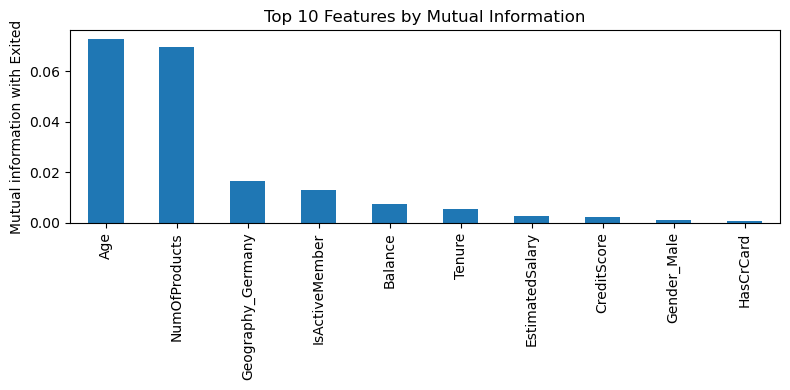

In [8]:
plt.figure(figsize=(8,4))
mi_series.head(10).plot(kind='bar')
plt.title('Top 10 Features by Mutual Information')
plt.ylabel('Mutual information with Exited')
plt.tight_layout()
plt.show()

## Build the ANN Model
We create a 3-layer ANN:
- Layer 1: Dense, ReLU activation
- Layer 2: Dense, ReLU activation
- Output Layer: Dense, Sigmoid activation for binary classification
- Optimizer: **adam**; Loss: **binary_crossentropy**.

In [9]:
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 337 (1.32 KB)

 Trainable params: 337 (1.32 KB)

 Non-trainable params: 0 (0.00 B)

## Train the Model
We fit the model on the training data for 50 epochs with a batch size of 32. (Early stopping is optional for stability.)

In [10]:
es = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1, callbacks=[es])

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 932us/step - accuracy: 0.6308 - loss: 0.6467  
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step - accuracy: 0.8065 - loss: 0.4593
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - accuracy: 0.8263 - loss: 0.4215
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step - accuracy: 0.8333 - loss: 0.4063
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step - accuracy: 0.8400 - loss: 0.3925
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step - accuracy: 0.8489 - loss: 0.3777
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8542 - loss: 0.3651  
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step - accuracy: 0.8565 - loss: 0.3565
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8600 - loss: 0.3504  
Epoch 10/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step - accuracy: 0.8619 - loss: 0.3458
Epoch 11/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step - accuracy: 0.8636 - loss: 0.3424
Epoch 12/50
250/250 ━━━━━━━━

## Evaluate the Model
We make predictions on the test set, generate a confusion matrix, and calculate the accuracy score.

In [11]:
y_prob = model.predict(X_test).ravel()
y_pred = (y_prob >= 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)

print("Confusion Matrix:\n", cm)
tn, fp, fn, tp = cm.ravel()
print(f"TN={tn}, FP={fp}, FN={fn}, TP={tp}")
print(f"\nAccuracy: {acc*100:.2f}%")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Confusion Matrix:
 [[1536   57]
 [ 219  188]]
TN=1536, FP=57, FN=219, TP=188

Accuracy: 86.20%


## Visualize Training Accuracy and Loss
We plot training accuracy and loss curves to see how the model learned over epochs.

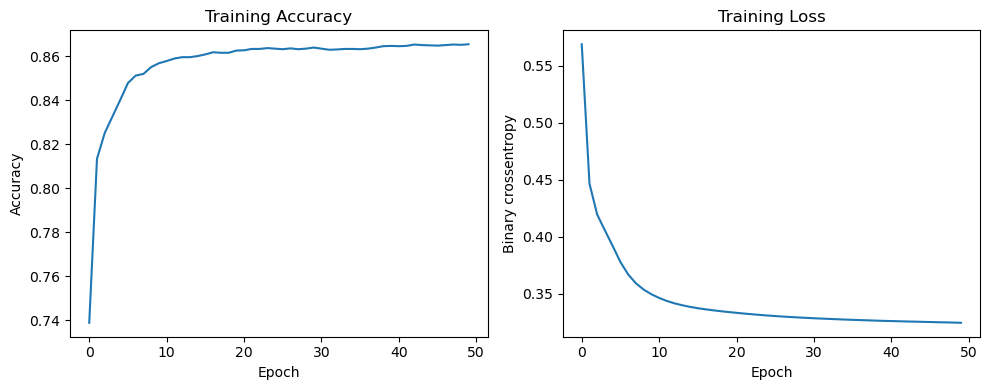

In [12]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.title('Training Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.title('Training Loss')
plt.xlabel('Epoch'); plt.ylabel('Binary crossentropy')

plt.tight_layout()
plt.show()

## Conclusion
The analysis identified Age, IsActiveMember, and Balance as the most influential numeric factors in predicting customer churn based on correlation with the target. Mutual information analysis further highlighted Age, NumOfProducts, and Geography_Germany as top contributors when categorical features were included.

The three-layer ANN classifier, built with ReLU activation in the hidden layers and a Sigmoid output layer, achieved an accuracy of 86.20% on the 20% test set. The confusion matrix shows:

True Negatives (TN): 1,536

False Positives (FP): 57

False Negatives (FN): 219

True Positives (TP): 188

This indicates the model performs well overall, particularly in correctly identifying non-churners (class 0), but there is still room for improvement in detecting churners (class 1). Future improvements could involve hyperparameter tuning, adjusting class weights to handle the slight imbalance, or exploring more complex architectures.